In [18]:
import os
import matplotlib.pyplot as plt
import numpy as np
import librosa.display
import librosa
from scipy.signal import spectrogram
from scipy.signal import find_peaks
# from scipy.io import wavfile


### generate spectrogram using scipy (not recommended)

In [16]:
# def generate_spectrogram_using_scipy(input_folder, output_folder):
#     directories_names = os.listdir(input_folder)
#     if not os.path.exists(output_folder):
#         os.makedirs(output_folder)

#     for directory in directories_names:
#         selected_folder = os.path.join(input_folder, directory)
#         for file in os.listdir(selected_folder):
#             if file.endswith('.wav'):
#                 file_path = os.path.join(selected_folder, file)
#                 samplerate, data = wavfile.read(file_path)

#                 # Ensure data is mono for simplicity
#                 if len(data.shape) > 1:
#                     data = np.mean(data, axis=1)

#                 # Trim to first 30 seconds
#                 data = data[:samplerate * 20]

#                 # Generate spectrogram
#                 frequencies, times, Sxx = spectrogram(data, fs=samplerate)
#                 plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
#                 plt.colorbar(label='Intensity [dB]')
#                 plt.title(f"Spectrogram: {file}")
#                 plt.xlabel('Time [s]')
#                 plt.ylabel('Frequency [Hz]')

#                 # Save the spectrogram
#                 output_file = os.path.join(output_folder, f"{file}_spectrogram.png")
#                 plt.savefig(output_file)
#                 plt.close()
                
#                 # save the spectrogram data as npy
#                 output_file = os.path.join(output_folder, f"{file}_spectrogram.npy")
#                 np.save(output_file, Sxx)

# generate spectrogram using librosa

In [33]:
def generate_spectrogram_using_librosa(input_folder, output_folder):
    # Generate spectrogram using librosa from audio files in input_folder
    directories_names = os.listdir(input_folder)
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for directory in directories_names:
        selected_folder = os.path.join(input_folder, directory)
        for file in os.listdir(selected_folder):
            if file.endswith('.wav'):
                file_path = os.path.join(selected_folder, file)
                audio_data, sample_rate = librosa.load(file_path, sr=None)

                # Ensure data is mono for simplicity
                if len(audio_data.shape) > 1:
                    audio_data = np.mean(audio_data, axis=1)

                # Trim to first 30 seconds
                audio_data = audio_data[:sample_rate * 20]

                S = np.abs(librosa.stft(audio_data))
                S_db = librosa.amplitude_to_db(S, ref=np.max)

                plt.figure(figsize=(10, 6))
                librosa.display.specshow(S_db, sr=sample_rate, x_axis="time", y_axis="hz", cmap='magma')
                plt.colorbar(label="Intensity [dB]")
                plt.title("Spectrogram")
                plt.xlabel("Time [s]")  
                plt.ylabel("Frequency [Hz]")
                plt.show()

                # Save the spectrogram using librosa
                output_file = os.path.join(output_folder, f"{file}_spectrogram.png")
                plt.savefig(output_file, bbox_inches='tight', facecolor='w', edgecolor='w')
                plt.close()

                # save the spectrogram data as npy
                output_file = os.path.join(output_folder, f"{file}_spectrogram.npy")
                np.save(output_file, S_db)

In [15]:
def extract_features(data, samplerate):
    # Extract peaks
    frequencies, times, Sxx = spectrogram(data, fs=samplerate)
    features = []

    for i in range(Sxx.shape[1]):
        peaks, _ = find_peaks(Sxx[:, i], height=0.5 * np.max(Sxx[:, i]))
        features.append(frequencies[peaks])

    return features


In [22]:
def plot_spectrogram_with_peaks(data, sample_rate, title="Spectrogram with Peaks"):
    try:
        # Parameters for the STFT
        n_fft = 1024
        hop_length = 512

        # Compute the STFT using numpy
        num_segments = (len(data) - n_fft) // hop_length + 1
        S = np.empty((n_fft // 2 + 1, num_segments))
        for i in range(num_segments):
            start = i * hop_length
            segment = data[start:start + n_fft] * np.hanning(n_fft)  # Apply a window function
            fft_segment = np.fft.rfft(segment)
            S[:, i] = np.abs(fft_segment) ** 2  # Power spectrum

        # Frequency and time axes
        freqs = np.fft.rfftfreq(n_fft, d=1/sample_rate)
        times = np.arange(num_segments) * hop_length / sample_rate

        # Convert to dB scale
        S_db = 10 * np.log10(S + 1e-10)  # Adding a small value to avoid log(0)

        # Plot the spectrogram
        plt.figure(figsize=(10, 6))
        plt.pcolormesh(times, freqs, S_db, shading='gouraud', cmap='viridis')
        plt.colorbar(label="Magnitude (dB)")
        plt.title(title)
        plt.xlabel("Time (s)")
        plt.ylabel("Frequency (Hz)")

        # Find peaks for each time slice (frequency axis)
        for i in range(S_db.shape[1]):  # Loop over time slices
            peaks, _ = find_peaks(S_db[:, i], height=np.max(S_db[:, i]) * 0.5)  # Adjust height threshold
            peak_freqs = freqs[peaks]
            peak_times = [times[i]] * len(peaks)
            print (peak_freqs)

            # Plot the peaks
            plt.scatter(peak_times, peak_freqs, color='red', s=10)

        plt.show()
        return peak_freqs

    except Exception as e:
        print(f"An error occurred while plotting the spectrogram: {e}")

def play_audio(audio_data, sample_rate=44100):
    """
    Plays the audio data.

    Parameters:
        audio_data (numpy.ndarray): The audio signal data.
        sample_rate (int): The sample rate of the audio data.
    """
    # Normalize audio for IPython playback
    normalized_audio = np.int16(audio_data / np.max(np.abs(audio_data)) * 32767)

    # Temporary WAV file (to allow playback in Jupyter)
    write("temp_audio.wav", sample_rate, normalized_audio)
    return ipd.Audio("temp_audio.wav")

def plot_magnitude(ft_data, _frequencies):
    """
    Plots the magnitude of the Fourier Transform.
    :param _frequencies:
    :param ft_data:
    :return:
    """
    _ft_magnitude = np.abs(ft_data)
    plt.figure(figsize=(10, 6))
    plt.plot(_frequencies, _ft_magnitude)
    plt.title("Fourier Transform")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Magnitude")
    plt.show()

def inverse_ft(ft_data):
    _shifted_ft = np.fft.ifftshift(ft_data)
    _filtered_signal = np.fft.ifft(_shifted_ft)
    _filtered_signal = np.real(_filtered_signal)
    return _filtered_signal

def export_to_file(audio_data, file_name, sample_rate=44100):
    """
    Exports the audio data to a file.

    Parameters:
        audio_data (numpy.ndarray): The audio signal data.
        sample_rate (int): The sample rate of the audio data.
        file_name (str): The name of the file to save the audio data to.
    """
    # Normalize audio for IPython playback
    normalized_audio = np.int16(audio_data / np.max(np.abs(audio_data)) * 32767)

    # Save the audio data to a WAV file
    write(file_name, sample_rate, normalized_audio)

# testing functions

[[-43.67974  -49.43598  -80.       ... -39.55384  -53.527508 -29.982548]
 [-43.880363 -50.43631  -59.465176 ... -41.681107 -45.01799  -28.387054]
 [-46.025    -47.648064 -48.57833  ... -41.173023 -43.117546 -26.08131 ]
 ...
 [-71.17998  -76.59942  -80.       ... -80.       -80.       -80.      ]
 [-70.68118  -76.38048  -80.       ... -80.       -80.       -80.      ]
 [-70.52821  -75.58478  -80.       ... -80.       -80.       -80.      ]]
Shape: (1025, 1723)
Data type: float32
[[8.91824057e+01 6.46786002e+01 1.17602808e+00 ... 2.31285406e+02
  1.23904248e+01 4.29029634e+01]
 [4.25053571e+01 9.24045775e+02 3.83213237e+03 ... 2.37278658e+03
  2.99746505e+04 4.00707494e+03]
 [6.20879425e+02 1.77496655e+03 7.45142756e+02 ... 4.22585913e+03
  3.82781083e+03 2.15669838e+04]
 ...
 [1.00538407e-03 6.82212510e-06 4.21535616e-05 ... 3.26164244e-03
  1.74052054e-03 1.67234799e-03]
 [2.48142985e-04 1.00319570e-04 3.37153642e-05 ... 9.52447721e-04
  5.59833962e-04 5.59309721e-03]
 [1.35179149e-03 

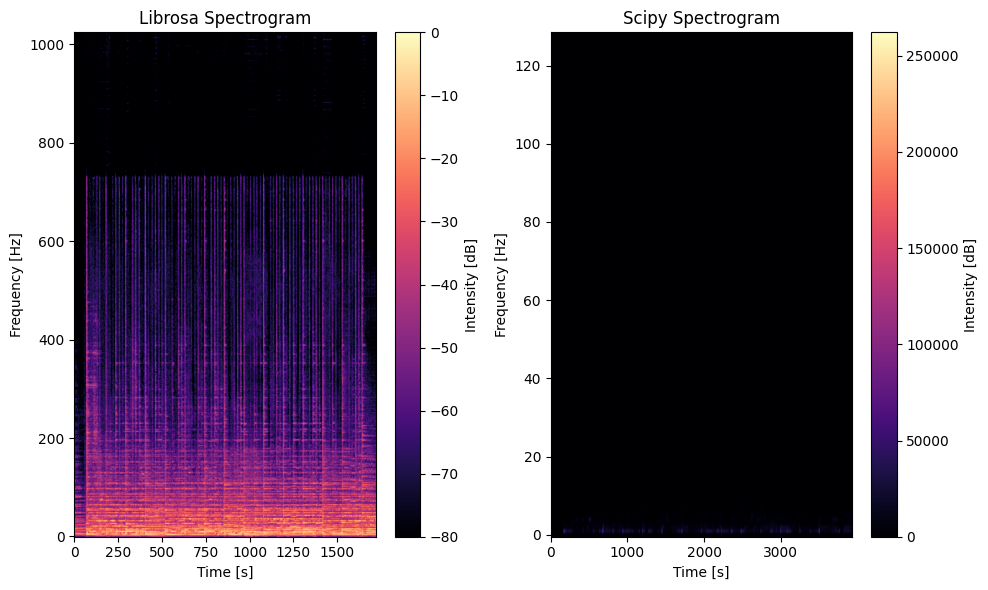

In [35]:
# Load the .npy file
librosa_data = np.load("Task 5 Data/generated spectrogram librosa/A Thousand Years(instruments).wav_spectrogram.npy")

# Display the loaded data
print(librosa_data)

# Check the shape and type of the data
print(f"Shape: {librosa_data.shape}")
print(f"Data type: {librosa_data.dtype}")

scipy_data = np.load("Task 5 Data/generated spectrogram/A Thousand Years(instruments).wav_spectrogram.npy")

# Display the loaded data
print(scipy_data)

# Check the shape and type of the data
print(f"Shape: {scipy_data.shape}")
print(f"Data type: {scipy_data.dtype}")

# compare the two spectrograms
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(librosa_data, aspect='auto', origin='lower', cmap='magma')
plt.colorbar(label='Intensity [dB]')
plt.title("Librosa Spectrogram")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.subplot(1, 2, 2)
plt.imshow(scipy_data, aspect='auto', origin='lower', cmap='magma')
plt.colorbar(label='Intensity [dB]')
plt.title("Scipy Spectrogram")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.tight_layout()
plt.show()


## generate the spectrograms with librosa (2d nparray)

In [ ]:
input_folder = "Task 5 Data/original data"
output_folder = "Task 5 Data/generated spectrogram librosa"
generate_spectrogram_using_librosa(input_folder, output_folder)

In [ ]:
input_folder = "Task 5 Data/original data"
output_folder = "Task 5 Data/generated spectrogram librosa"
generate_spectrogram_using_librosa(input_folder, output_folder)